Install deps

In [2]:
!export PYTORCH_CUDA_ALLOC_CONF=max_split_size_mb:512

In [3]:
#!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/examples/dreambooth/train_dreambooth.py -O train_dreambooth_ShivamShrirao.py
#!wget -q https://raw.githubusercontent.com/ShivamShrirao/diffusers/6f3cbefb6a0aa13340613b4dafea5d8bb53e51f3/examples/dreambooth/train_dreambooth.py -O train_dreambooth_ShivamShrirao.py
#!wget -q https://github.com/ShivamShrirao/diffusers/raw/main/scripts/convert_diffusers_to_original_stable_diffusion.py
%pip install -qq git+https://github.com/ShivamShrirao/diffusers.git@25045fd
%pip install -q -U --pre triton==2.0.0.dev20230217
%pip install -q accelerate==0.12.0 transformers==4.24.0 ftfy==6.1.1 bitsandbytes==0.35.0 gradio==3.20.1 natsort==8.3.1
#%pip install -q https://github.com/brian6091/xformers-wheels/releases/download/0.0.15.dev0%2B4c06c79/xformers-0.0.15.dev0+4c06c79.d20221205-cp38-cp38-linux_x86_64.whl
%pip install xformers
%pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.0 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 15.1 MB/s eta 0:00:0000:0100:01
  Using cached pyre_extensions-0.0.23-py3-none-any.whl (11 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 887.4/887.4 MB 958.7 kB/s eta 0:00:0000:0100:01
  Using cached typing_inspect-0.8.0-py3-none-any.whl (8.7 kB)
  Using cached nvidia_cuda_nvrtc_cu11-11.7.99-2-py3-none-manylinux1_x86_64.whl (21.0 MB)
  Using cached nvidia_cuda_runtime_cu11-11.7.99-py3-none-manylinux1_x86_64.whl (849 kB)
  Using cached nvidia_cudnn_cu11-8.5.0.96-2-py3-none-manylinux1_x86_64.whl (557.1 MB)
  Using ca

In [37]:
import torch
import random

torch.cuda.empty_cache()  

Login to HuggingFace and settings

In [10]:
!mkdir -p ~/.huggingface

#ONLY RUN ONCE
#HUGGINGFACE_TOKEN = "INSERT_TOKEN_HERE" 
#!echo -n "{HUGGINGFACE_TOKEN}" > ~/.huggingface/token

MODEL_NAME = "runwayml/stable-diffusion-v1-5"

OUTPUT_DIR = "stable_diffusion_weights/cc" 
OUTPUT_DIR = "./content/" + OUTPUT_DIR

print(f"[*] Weights will be saved at {OUTPUT_DIR}")

!mkdir -p $OUTPUT_DIR

[*] Weights will be saved at ./content/stable_diffusion_weights/cc


Check type of GPU and VRAM available
if this returns 'command not found' you are not using a GPU with your notebook

In [38]:
!nvidia-smi --query-gpu=name,memory.total,memory.free --format=csv,noheader

Tesla T4, 15109 MiB, 12009 MiB


Start training

In [12]:
# You can also add multiple concepts here. Try tweaking `--max_train_steps` accordingly.

concepts_list = [
#    {
#        "instance_prompt":      "photo of zwx dog",
#        "class_prompt":         "photo of a dog",
#        "instance_data_dir":    "./content/data/zwx",
#        "class_data_dir":       "./content/data/dog"
#    }, 

    {
         "instance_prompt":      "photo of cc person",
         "class_prompt":         "photo of a person",
         "instance_data_dir":    "./content/data/cc",
         "class_data_dir":       "./content/data/person"
    },  
]

# `class_data_dir` contains regularization images
import json
import os
for c in concepts_list:
    os.makedirs(c["instance_data_dir"], exist_ok=True)

with open("concepts_list_cc.json", "w") as f:
    json.dump(concepts_list, f, indent=4)

In [34]:
#!accelerate launch --help
!accelerate launch --mixed_precision="fp16" --num_processes=1 --num_machines=1 --num_cpu_threads_per_process=2 \
train_dreambooth_ShivamShrirao.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --pretrained_vae_name_or_path="stabilityai/sd-vae-ft-mse" \
  --output_dir=$OUTPUT_DIR \
  --revision="fp16" \
  --with_prior_preservation --prior_loss_weight=1.0 \
  --seed=1337 \
  --resolution=512 \
  --train_batch_size=1 \
  --train_text_encoder \
  --mixed_precision="fp16" \
  --use_8bit_adam \
  --gradient_accumulation_steps=1 \
  --learning_rate=5e-6 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --num_class_images=50 \
  --sample_batch_size=1 \
  --max_train_steps=1100 \
  --save_interval=10000 \
  --save_sample_prompt="photo of cc person" \
  --concepts_list="concepts_list_cc.json" \
  --gradient_checkpointing

/opt/conda/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: /opt/conda/lib/python3.8/site-packages/torchvision/image.so: undefined symbol: _ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIlEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  warn(f"Failed to load image Python extension: {e}")
/opt/conda/lib/python3.8/site-packages/accelerate/accelerator.py:179: UserWarning: `log_with=tensorboard` was passed but no supported trackers are currently installed.
  warnings.warn(f"`log_with={log_with}` was passed but no supported trackers are currently installed.")
mixed_precision set as fp16
loaded concepts_list from file

===================================BUG REPORT===================================
Welcome to bitsandbytes. For bug reports, please submit your error trace to: https://github.com/TimDettmers/bitsandbytes/issues
For effortless bug reporting copy-paste your 

UpdateWeights

In [17]:
WEIGHTS_DIR = "" 
if WEIGHTS_DIR == "":
    from natsort import natsorted
    from glob import glob
    import os
    WEIGHTS_DIR = natsorted(glob(OUTPUT_DIR + os.sep + "*"))[-1]
print(f"[*] WEIGHTS_DIR={WEIGHTS_DIR}")

[*] WEIGHTS_DIR=./content/stable_diffusion_weights/cc/1200


Generate a grid of preview images

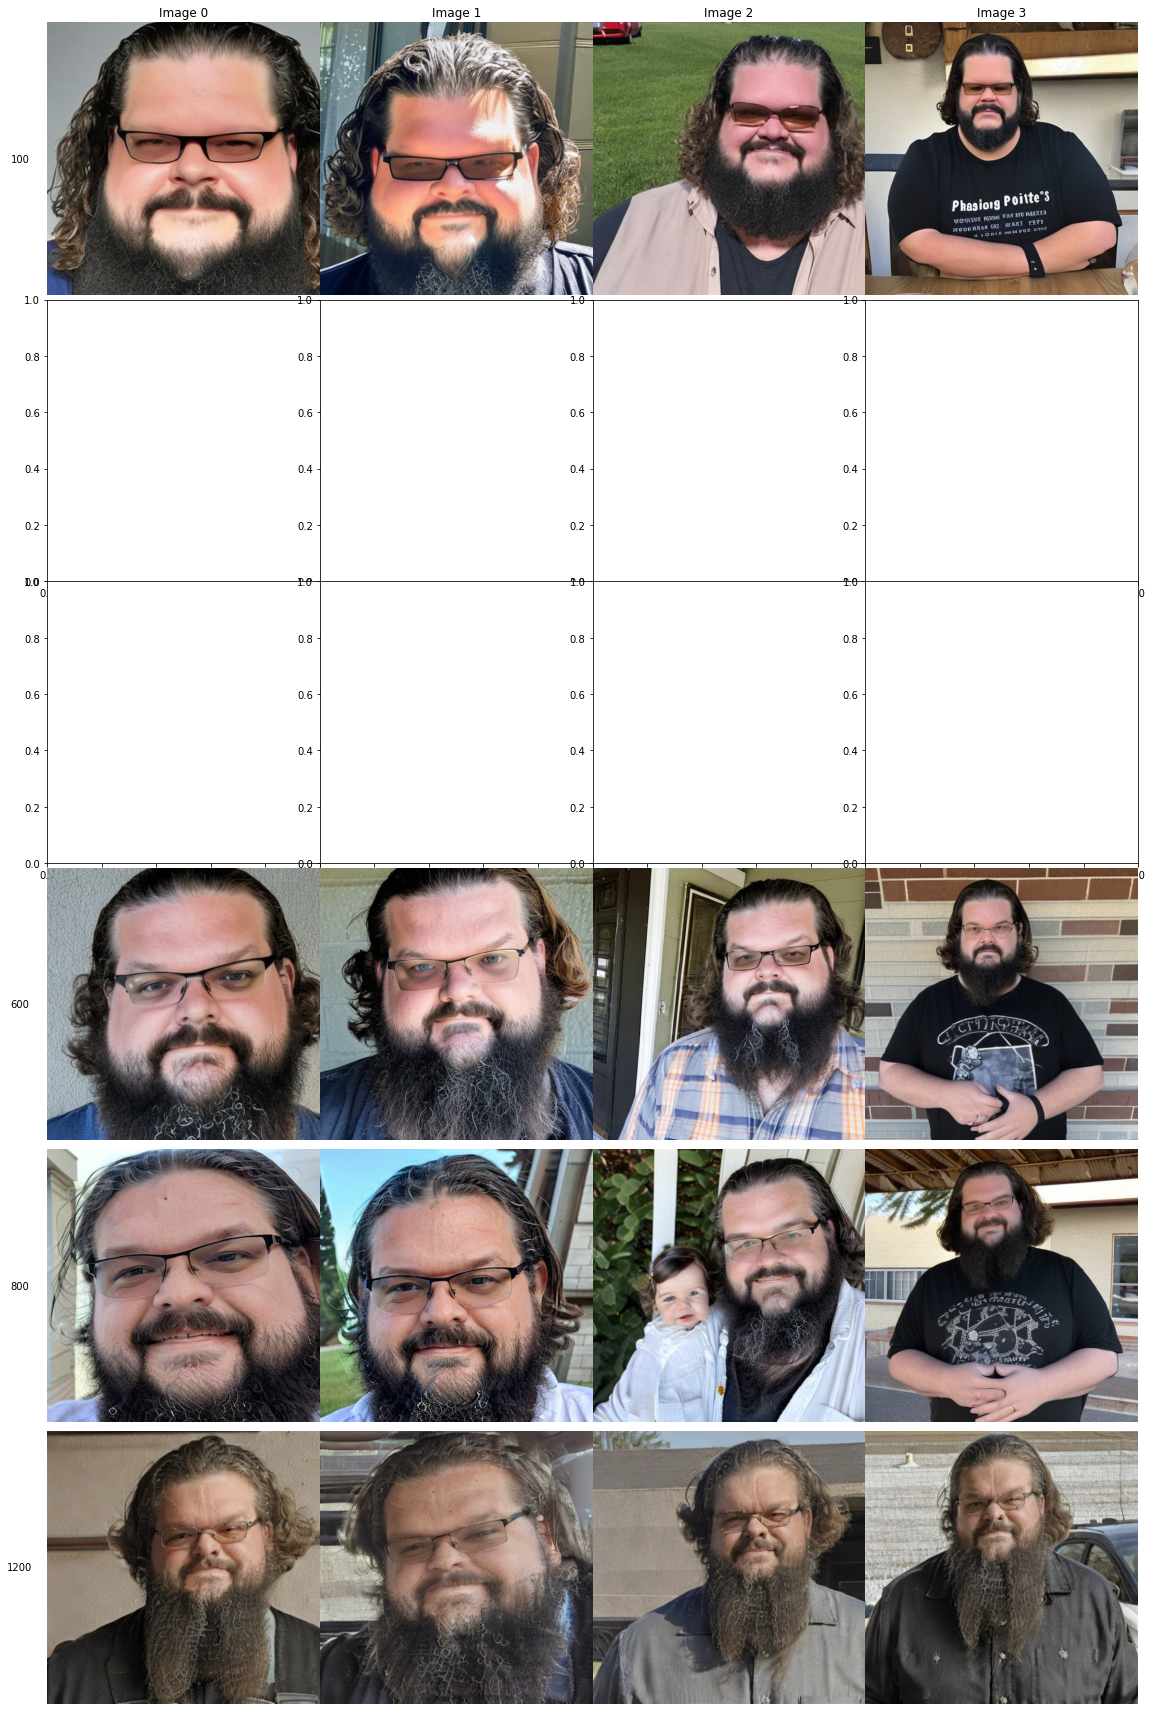

In [18]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

weights_folder = OUTPUT_DIR
folders = sorted([f for f in os.listdir(weights_folder) if f != "0"], key=lambda x: int(x))

row = len(folders)
col = len(os.listdir(os.path.join(weights_folder, folders[0], "samples")))
scale = 4
fig, axes = plt.subplots(row, col, figsize=(col*scale, row*scale), gridspec_kw={'hspace': 0, 'wspace': 0})

for i, folder in enumerate(folders):
    folder_path = os.path.join(weights_folder, folder)
    image_folder = os.path.join(folder_path, "samples")
    images = [f for f in os.listdir(image_folder)]
    for j, image in enumerate(images):
        if row == 1:
            currAxes = axes[j]
        else:
            currAxes = axes[i, j]
        if i == 0:
            currAxes.set_title(f"Image {j}")
        if j == 0:
            currAxes.text(-0.1, 0.5, folder, rotation=0, va='center', ha='center', transform=currAxes.transAxes)
        image_path = os.path.join(image_folder, image)
        img = mpimg.imread(image_path)
        currAxes.imshow(img, cmap='gray')
        currAxes.axis('off')
        
plt.tight_layout()
plt.savefig('content/grid.png', dpi=72)

Convert weights to ckpt to use in web UIs like AutoMatic1111

In [19]:
#@markdown Run conversion.
ckpt_path = WEIGHTS_DIR + "/model.ckpt"

half_arg = ""
#@markdown  Whether to convert to fp16, takes half the space (2GB).
fp16 = True #@param {type: "boolean"}
if fp16:
    half_arg = "--half"
!python convert_diffusers_to_original_stable_diffusion_ShivamShrirao.py --model_path $WEIGHTS_DIR  --checkpoint_path $ckpt_path $half_arg
print(f"[*] Converted ckpt saved at {ckpt_path}")

Reshaping encoder.mid.attn_1.q.weight for SD format
Reshaping encoder.mid.attn_1.k.weight for SD format
Reshaping encoder.mid.attn_1.v.weight for SD format
Reshaping encoder.mid.attn_1.proj_out.weight for SD format
Reshaping decoder.mid.attn_1.q.weight for SD format
Reshaping decoder.mid.attn_1.k.weight for SD format
Reshaping decoder.mid.attn_1.v.weight for SD format
Reshaping decoder.mid.attn_1.proj_out.weight for SD format
[*] Converted ckpt saved at ./content/stable_diffusion_weights/cc/1200/model.ckpt


Inference

In [ ]:
import torch
from torch import autocast
from diffusers import StableDiffusionPipeline, DDIMScheduler
from IPython.display import display

#model_path = WEIGHTS_DIR             # If you want to use previously trained model saved in gdrive, replace this with the full path of model in gdrive

model_path = './content/stable_diffusion_weights/cc/1200old'

scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
pipe = StableDiffusionPipeline.from_pretrained(model_path, scheduler=scheduler, safety_checker=None, torch_dtype=torch.float16).to("cuda")

g_cuda = None

In [21]:
#@markdown Can set random seed here for reproducibility.
g_cuda = torch.Generator(device='cuda')
seed = 52362 #@param {type:"number"}
g_cuda.manual_seed(random.randint(100, 60000))

In [ ]:
from datetime import datetime

prompt = "hyper-maximalist overdetailed comic book illustration headshot photo of cc person"

negative_prompt = "duplicate" #@param {type:"string"}
num_samples = 2 #@param {type:"number"}
guidance_scale = 5 #@param {type:"number"}
num_inference_steps = 100 #@param {type:"number"}
height = 512 #@param {type:"number"}
width = 512 #@param {type:"number"}

outerloop_iterations = 10

for i in range(outerloop_iterations):
    with autocast("cuda"), torch.inference_mode():
        images = pipe(
            prompt,
            height=height,
            width=width,
            negative_prompt=negative_prompt,
            num_images_per_prompt=num_samples,
            num_inference_steps=num_inference_steps,
            guidance_scale=guidance_scale,
            generator=g_cuda
        ).images

    for img in images:
            dt = datetime.now() 
            ts = datetime.timestamp(dt)

            display(img)
            img.save('./content/ccOutputs/'+str(ts) + ".jpg", "JPEG")

In [ ]:
#@title (Optional) Delete diffuser and old weights and only keep the ckpt to free up drive space.

#@markdown [ ! ] Caution, Only execute if you are sure u want to delete the diffuser format weights and only use the ckpt.
import shutil
from glob import glob
import os
for f in glob(OUTPUT_DIR+os.sep+"*"):
    if f != WEIGHTS_DIR:
        shutil.rmtree(f)
        print("Deleted", f)
for f in glob(WEIGHTS_DIR+"/*"):
    if not f.endswith(".ckpt") or not f.endswith(".json"):
        try:
            shutil.rmtree(f)
        except NotADirectoryError:
            continue
        print("Deleted", f)

In [ ]:
#@title Free runtime memory
exit()